## Setup

Import libraries and load data for a specific dataset.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Configure paths
dataset_name = "bellevue_116th_ne12th"  # Change to your dataset
processed_dir = Path(f"../data/processed/{dataset_name}")

# Load data
outliers = pd.read_parquet(processed_dir / "outliers.parquet")
clusters = pd.read_parquet(processed_dir / "clusters.parquet")
trajs = pd.read_parquet(processed_dir / "trajectories.parquet")

print(f"Loaded {len(outliers)} outliers, {len(clusters)} total tracks")

Loaded 18612 outliers, 19827 total tracks


In [65]:
outliers

,track_id,index,x_entry,y_entry,x_exit,y_exit,reachability,is_unreachable
0,1,0,0.711995,0.682180,1.531162,0.462875,0.399410,True
1,11828,11822,1.859045,0.992652,0.375000,0.783333,0.399410,True
2,2851,2850,1.458569,0.788502,1.917572,1.044916,0.399410,True
3,18884,18265,1.047222,0.780556,1.063194,0.817361,0.399410,True
4,11869,11863,1.873708,0.298165,0.985800,0.912652,0.399410,True
...,...,...,...,...,...,...,...,...
18607,10183,10179,0.908851,0.236747,0.887601,0.195526,0.024216,False
18608,3452,3451,0.901048,0.220021,0.905046,0.256178,0.023693,False
18609,21026,19561,0.892130,0.227563,0.917854,0.252210,0.023630,False
18610,17387,17179,0.892117,0.215105,0.920109,0.253590,0.023158,False


In [66]:
clusters

,track_id,cluster
0,1,-1
1,2,-1
2,3,-1
3,4,-1
4,5,-1
...,...,...
19822,21692,-1
19823,21693,-1
19824,21695,-1
19825,21699,-1


In [67]:
trajs

,track_id,frame,x,y,vx,vy,ax,ay
0,1,1,0.711995,0.682180,-4.019886,-1.008081,26.989989,2.034632
1,1,1,0.577999,0.648577,-3.120220,-0.940260,40.484984,3.051948
2,1,1,0.503980,0.619496,-1.320887,-0.804618,53.979978,4.069264
3,1,1,0.489940,0.594936,0.478445,-0.668975,45.030100,-1.031791
4,1,1,0.535877,0.574898,1.681119,-0.873404,71.659226,7.134199
...,...,...,...,...,...,...,...,...
18841570,21701,107954,0.350000,0.548611,0.000000,0.000000,0.000000,0.000000
18841571,21701,107955,0.350000,0.548611,0.000000,0.000000,0.000000,-0.156250
18841572,21701,107956,0.350000,0.548611,0.000000,-0.010417,0.156250,0.000000
18841573,21701,107957,0.350000,0.547917,0.010417,0.000000,0.312500,0.468750


## Overview Statistics

Calculate basic statistics about outliers and their reachability distances.

In [68]:
# Basic stats
n_outliers = len(outliers)
n_total = len(clusters)
n_clustered = (clusters['cluster'] >= 0).sum()

print(f"Total tracks: {n_total}")
print(f"Clustered: {n_clustered} ({100.0*n_clustered/n_total:.1f}%)")
print(f"Outliers: {n_outliers} ({100.0*n_outliers/n_total:.1f}%)")

# Reachability stats
n_unreachable = outliers['is_unreachable'].sum() if 'is_unreachable' in outliers.columns else 0
print(f"\nReachability range: [{outliers['reachability'].min():.3f}, {outliers['reachability'].max():.3f}]")
print(f"Mean: {outliers['reachability'].mean():.3f}")
print(f"Median: {outliers['reachability'].median():.3f}")
if n_unreachable > 0:
    print(f"\nCompletely unreachable outliers: {n_unreachable} ({100.0*n_unreachable/n_outliers:.1f}%)")

Total tracks: 19827
Clustered: 1215 (6.1%)
Outliers: 18612 (93.9%)

Reachability range: [0.023, 0.399]
Mean: 0.087
Median: 0.070

Completely unreachable outliers: 427 (2.3%)


## Visualize Spatial Distribution

Plot where outliers enter and exit the scene, colored by reachability distance.

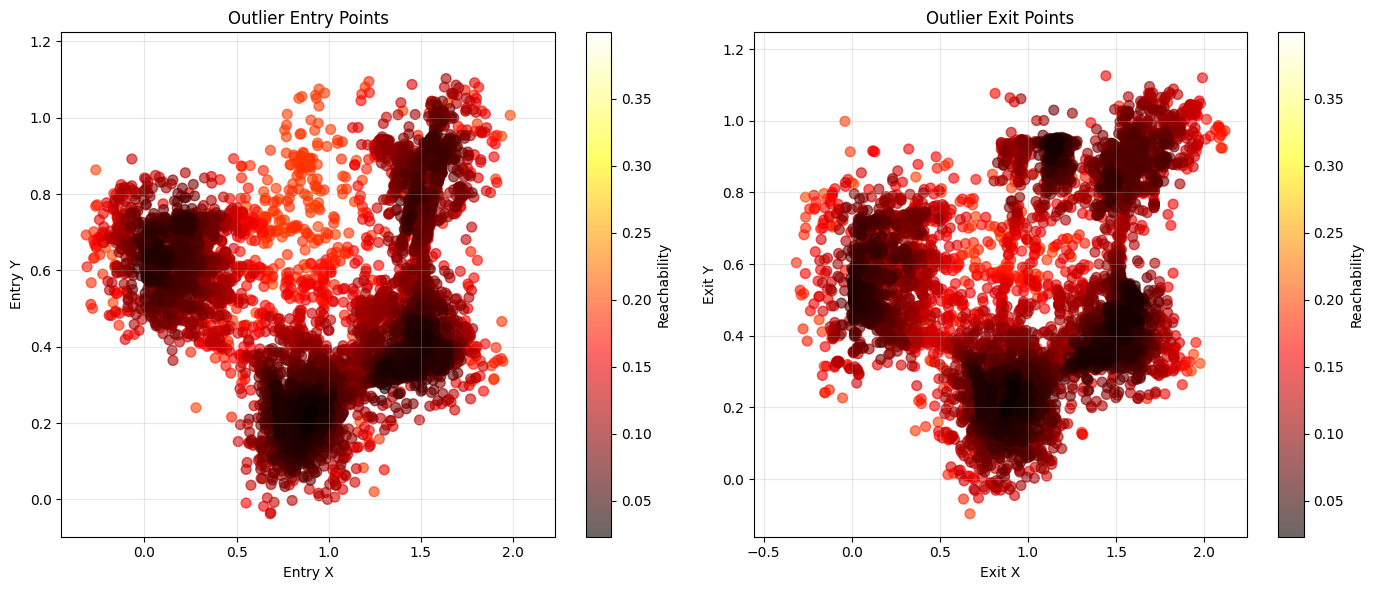

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Entry points
ax = axes[0]
scatter = ax.scatter(outliers['x_entry'], outliers['y_entry'], 
                    c=outliers['reachability'], cmap='hot', alpha=0.6, s=50)
ax.set_xlabel('Entry X')
ax.set_ylabel('Entry Y')
ax.set_title('Outlier Entry Points')
plt.colorbar(scatter, ax=ax, label='Reachability')
ax.grid(True, alpha=0.3)

# Exit points
ax = axes[1]
scatter = ax.scatter(outliers['x_exit'], outliers['y_exit'],
                    c=outliers['reachability'], cmap='hot', alpha=0.6, s=50)
ax.set_xlabel('Exit X')
ax.set_ylabel('Exit Y')
ax.set_title('Outlier Exit Points')
plt.colorbar(scatter, ax=ax, label='Reachability')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Examine Individual Outliers

List the top 20 most anomalous trajectories with their details.

In [70]:
# Sort by reachability and show top anomalies
top_outliers = outliers.sort_values('reachability', ascending=False).head(20)

for idx, row in top_outliers.iterrows():
    track_id = row['track_id']
    track_data = trajs[trajs['track_id'] == track_id]
    
    print(f"\nTrack {track_id} (reachability={row['reachability']:.3f})")
    print(f"  Duration: {len(track_data)} frames")
    print(f"  Entry: ({row['x_entry']:.3f}, {row['y_entry']:.3f})")
    print(f"  Exit: ({row['x_exit']:.3f}, {row['y_exit']:.3f})")
    print(f"  Position range: X=[{track_data['x'].min():.3f}, {track_data['x'].max():.3f}], "
          f"Y=[{track_data['y'].min():.3f}, {track_data['y'].max():.3f}]")


Track 1 (reachability=0.399)
  Duration: 7941 frames
  Entry: (0.712, 0.682)
  Exit: (1.531, 0.463)
  Position range: X=[0.143, 1.544], Y=[0.317, 0.710]

Track 8985 (reachability=0.399)
  Duration: 305 frames
  Entry: (1.921, 0.492)
  Exit: (0.328, 0.623)
  Position range: X=[0.015, 1.921], Y=[0.437, 0.642]

Track 14212 (reachability=0.399)
  Duration: 161 frames
  Entry: (1.996, 1.008)
  Exit: (1.028, 0.239)
  Position range: X=[0.699, 1.996], Y=[0.239, 1.008]

Track 17923 (reachability=0.399)
  Duration: 14 frames
  Entry: (0.578, 0.615)
  Exit: (0.730, 0.601)
  Position range: X=[0.578, 0.730], Y=[0.601, 0.616]

Track 761 (reachability=0.399)
  Duration: 2481 frames
  Entry: (0.895, 0.693)
  Exit: (0.345, 0.723)
  Position range: X=[-0.033, 1.651], Y=[0.121, 0.872]

Track 14057 (reachability=0.399)
  Duration: 207 frames
  Entry: (1.043, 0.739)
  Exit: (0.981, 0.422)
  Position range: X=[0.367, 1.481], Y=[0.115, 0.978]

Track 14348 (reachability=0.399)
  Duration: 2205 frames
  Ent

## Plot Individual Trajectory

Define a function to visualize any trajectory with velocity vectors.

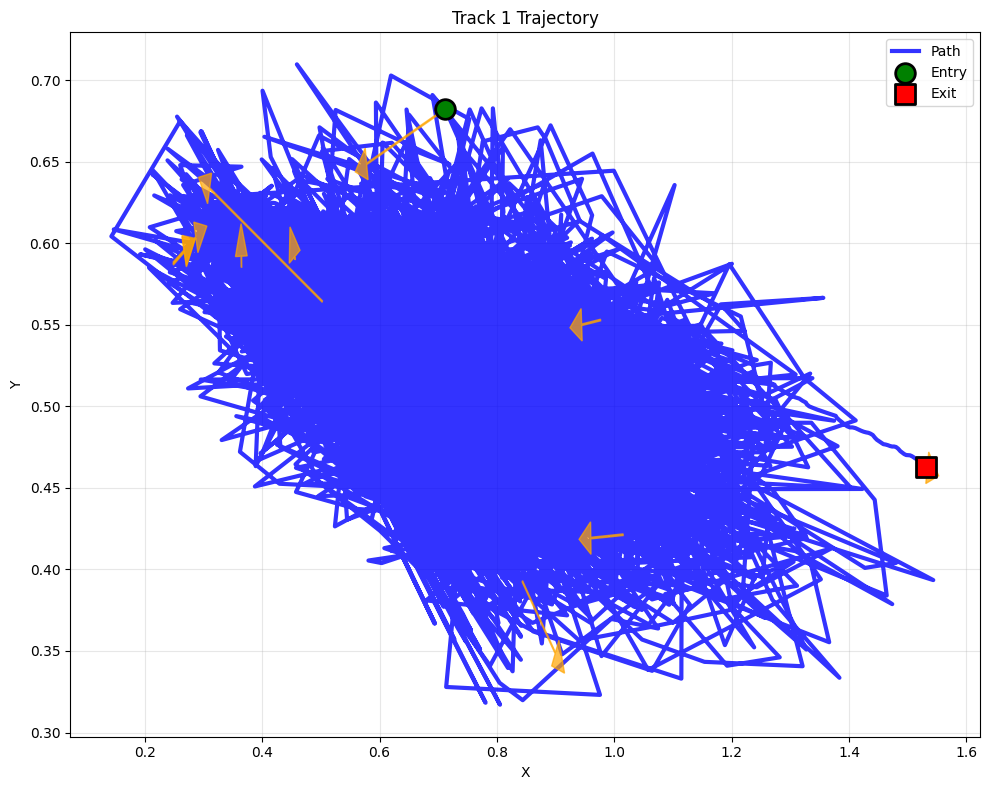

In [71]:
def plot_trajectory(track_id, ax=None, show_background=False, background_alpha=0.1):
    """Plot a single trajectory with velocity vectors.
    
    Parameters
    ----------
    track_id : int
        Track ID to plot
    ax : matplotlib axis, optional
        Axis to plot on
    show_background : bool
        If True, show all other trajectories as context
    background_alpha : float
        Transparency for background trajectories
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    track_data = trajs[trajs['track_id'] == track_id].sort_values('frame')
    
    # Plot background trajectories if requested
    if show_background:
        for tid in trajs['track_id'].unique():
            if tid != track_id:
                bg_data = trajs[trajs['track_id'] == tid].sort_values('frame')
                ax.plot(bg_data['x'], bg_data['y'], 'gray', alpha=background_alpha, linewidth=0.5, zorder=1)
    
    # Main trajectory path
    ax.plot(track_data['x'], track_data['y'], 'b-', alpha=0.8, linewidth=3, label='Path', zorder=5)
    
    # Entry/exit markers
    ax.scatter(track_data['x'].iloc[0], track_data['y'].iloc[0], 
              c='green', s=200, marker='o', edgecolor='black', linewidth=2, label='Entry', zorder=10)
    ax.scatter(track_data['x'].iloc[-1], track_data['y'].iloc[-1],
              c='red', s=200, marker='s', edgecolor='black', linewidth=2, label='Exit', zorder=10)
    
    # Velocity vectors (sample every N points to avoid clutter)
    step = max(1, len(track_data) // 10)
    sample = track_data.iloc[::step]
    for _, row in sample.iterrows():
        ax.arrow(row['x'], row['y'], row['vx']/30, row['vy']/30,
                head_width=0.02, head_length=0.02, fc='orange', ec='orange', alpha=0.7, zorder=8)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Track {int(track_id)} Trajectory')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

# Plot the most anomalous trajectory (without overwhelming background)
most_anomalous_id = outliers.iloc[0]['track_id']
plot_trajectory(most_anomalous_id, show_background=False)
plt.tight_layout()
plt.show()

## Compare Outlier vs Normal Trajectories

Side-by-side comparison of an outlier and a normal clustered trajectory.

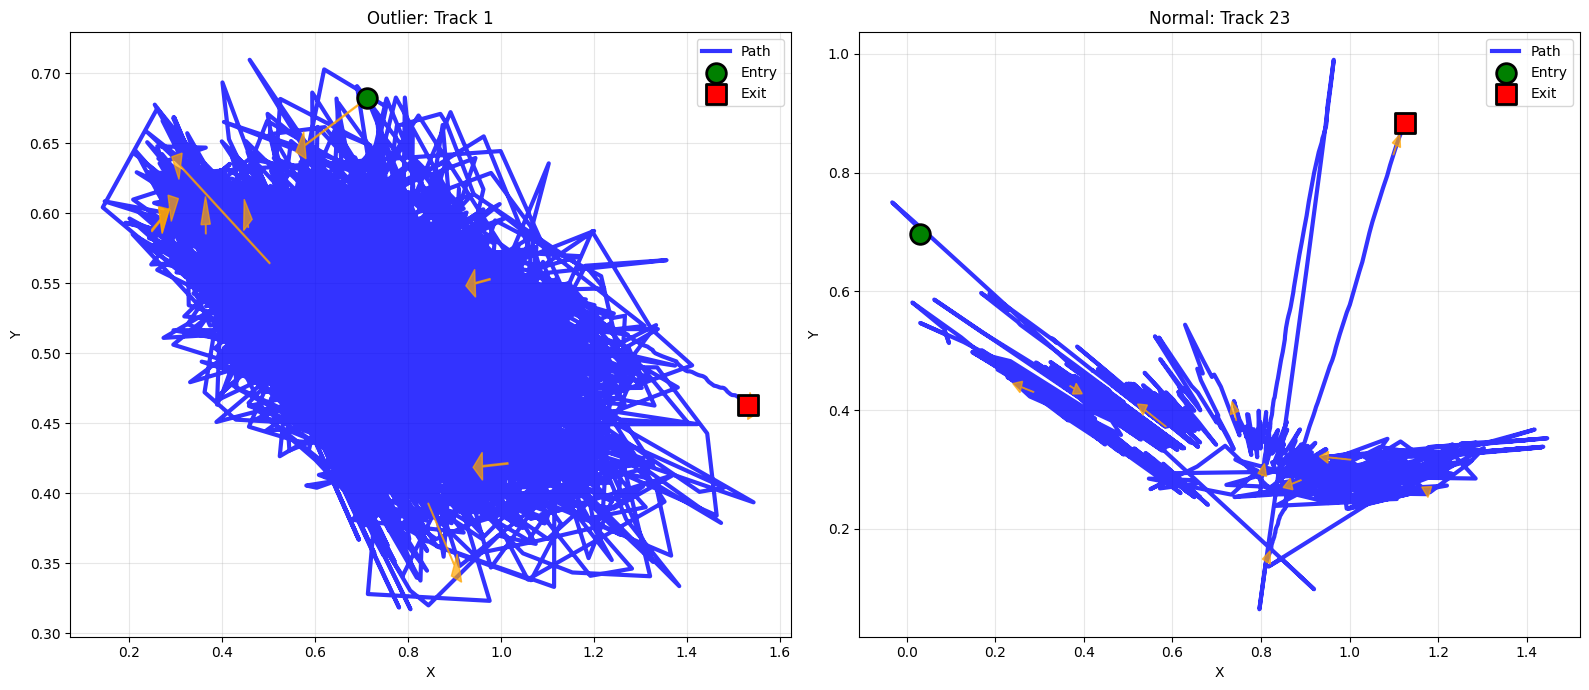

In [72]:
# Get a normal (clustered) trajectory for comparison
normal_track_id = clusters[clusters['cluster'] >= 0].iloc[0]['track_id']

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Outlier (no background clutter)
plot_trajectory(most_anomalous_id, ax=axes[0], show_background=False)
axes[0].set_title(f'Outlier: Track {int(most_anomalous_id)}')

# Normal (no background clutter)
plot_trajectory(normal_track_id, ax=axes[1], show_background=False)
axes[1].set_title(f'Normal: Track {int(normal_track_id)}')

plt.tight_layout()
plt.show()

## Debug: Inspect Multiple Normal Tracks

Let's look at several normal (clustered) tracks to understand their structure.

In [73]:
# Get several normal tracks from different clusters
normal_tracks = clusters[clusters['cluster'] >= 0].head(10)

print("Sample normal (clustered) tracks:")
for idx, row in normal_tracks.iterrows():
    track_id = row['track_id']
    cluster_id = row['cluster']
    track_data = trajs[trajs['track_id'] == track_id]
    
    print(f"\nTrack {track_id} (Cluster {cluster_id}):")
    print(f"  Number of frames: {len(track_data)}")
    print(f"  X range: [{track_data['x'].min():.3f}, {track_data['x'].max():.3f}]")
    print(f"  Y range: [{track_data['y'].min():.3f}, {track_data['y'].max():.3f}]")
    print(f"  Entry: ({track_data.iloc[0]['x']:.3f}, {track_data.iloc[0]['y']:.3f})")
    print(f"  Exit: ({track_data.iloc[-1]['x']:.3f}, {track_data.iloc[-1]['y']:.3f})")

Sample normal (clustered) tracks:

Track 23 (Cluster 1):
  Number of frames: 1336
  X range: [-0.033, 1.446]
  Y range: [0.065, 0.990]
  Entry: (0.029, 0.697)
  Exit: (1.126, 0.883)

Track 46 (Cluster 9):
  Number of frames: 2638
  X range: [0.059, 1.763]
  Y range: [0.139, 0.997]
  Entry: (0.743, 0.179)
  Exit: (0.972, 0.928)

Track 152 (Cluster 8):
  Number of frames: 1599
  X range: [0.306, 1.649]
  Y range: [0.114, 0.665]
  Entry: (0.974, 0.235)
  Exit: (1.579, 0.453)

Track 170 (Cluster 0):
  Number of frames: 3892
  X range: [-0.112, 1.604]
  Y range: [0.144, 0.895]
  Entry: (0.021, 0.637)
  Exit: (1.598, 0.452)

Track 203 (Cluster 9):
  Number of frames: 1841
  X range: [0.071, 1.878]
  Y range: [0.095, 0.951]
  Entry: (0.797, 0.247)
  Exit: (0.955, 0.873)

Track 319 (Cluster 12):
  Number of frames: 1714
  X range: [-0.191, 1.739]
  Y range: [0.140, 0.944]
  Entry: (1.622, 0.944)
  Exit: (1.653, 0.867)

Track 375 (Cluster 9):
  Number of frames: 829
  X range: [-0.121, 1.733]
 

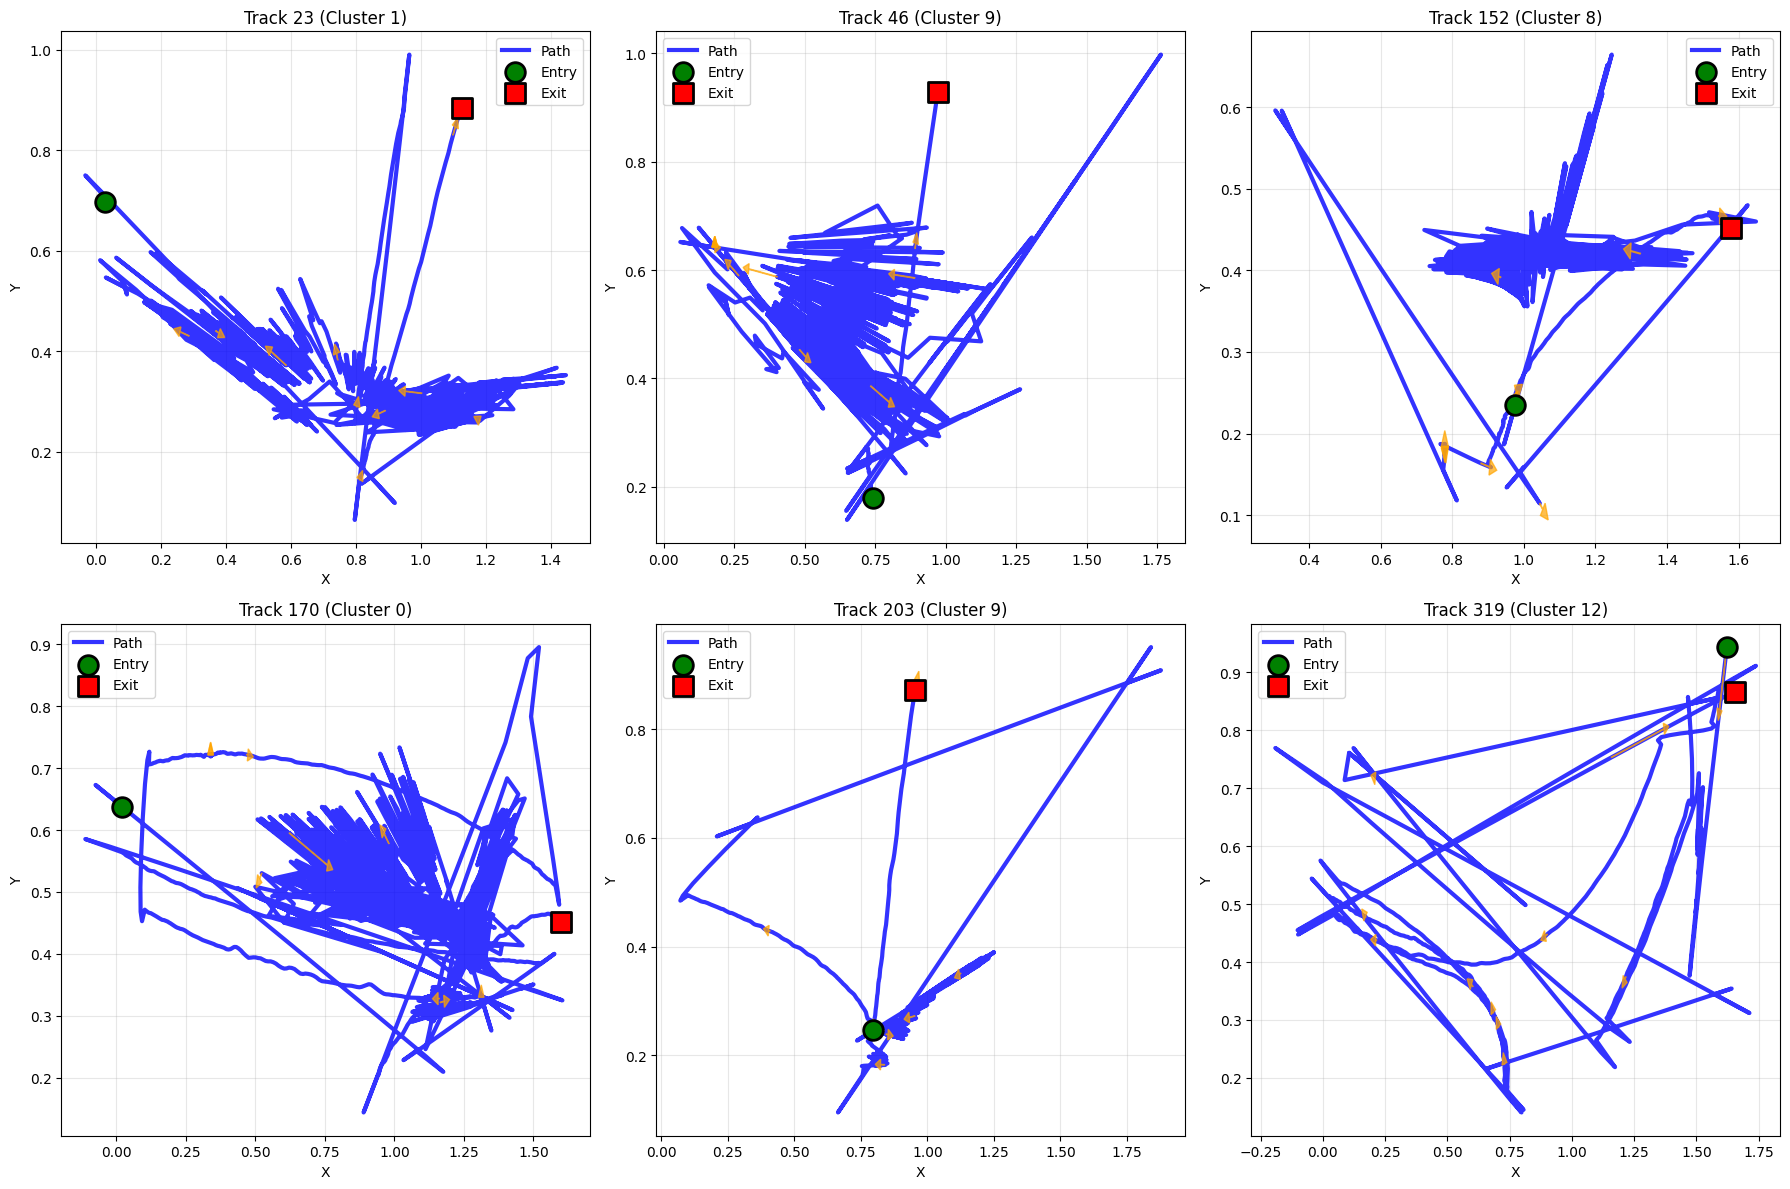

In [74]:
# Plot 6 normal tracks in a grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

normal_sample = clusters[clusters['cluster'] >= 0].head(6)

for idx, (_, row) in enumerate(normal_sample.iterrows()):
    track_id = row['track_id']
    cluster_id = row['cluster']
    
    plot_trajectory(track_id, ax=axes[idx], show_background=False)
    axes[idx].set_title(f'Track {int(track_id)} (Cluster {cluster_id})')

plt.tight_layout()
plt.show()

Comparing 3 tracks from the same cluster (Cluster 0):


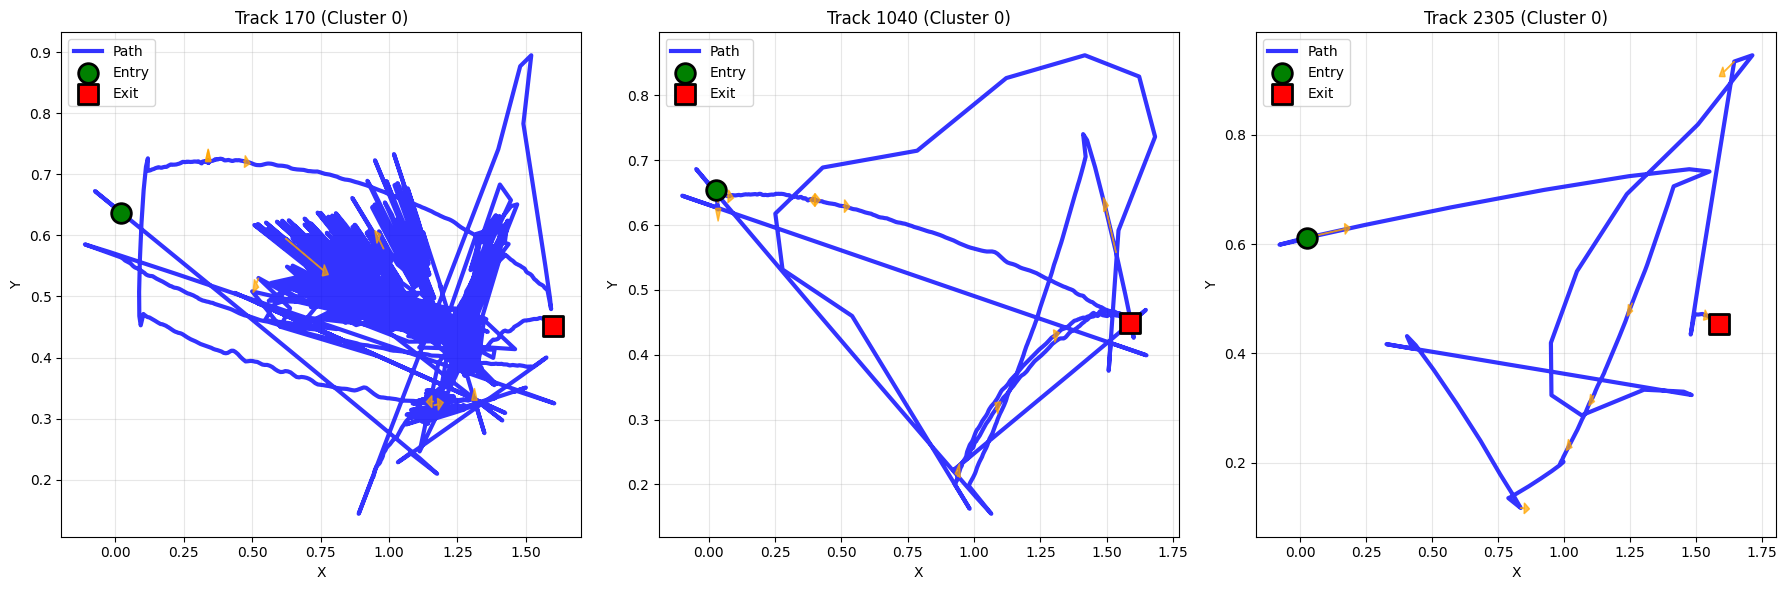


These should look similar since they're in the same cluster!


In [75]:
# Compare tracks from the same cluster vs different clusters
cluster_0_tracks = clusters[clusters['cluster'] == 0].head(3)

print("Comparing 3 tracks from the same cluster (Cluster 0):")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (_, row) in enumerate(cluster_0_tracks.iterrows()):
    track_id = row['track_id']
    plot_trajectory(track_id, ax=axes[idx], show_background=False)
    axes[idx].set_title(f'Track {int(track_id)} (Cluster 0)')

plt.tight_layout()
plt.show()

print("\nThese should look similar since they're in the same cluster!")

## Outlier in Context

View the outlier trajectory with all other trajectories shown as background (gray) to see why it's anomalous.

/var/folders/tj/0mk4td753wdf74lwb26db8lc0000gn/T/ipykernel_56604/2889636533.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


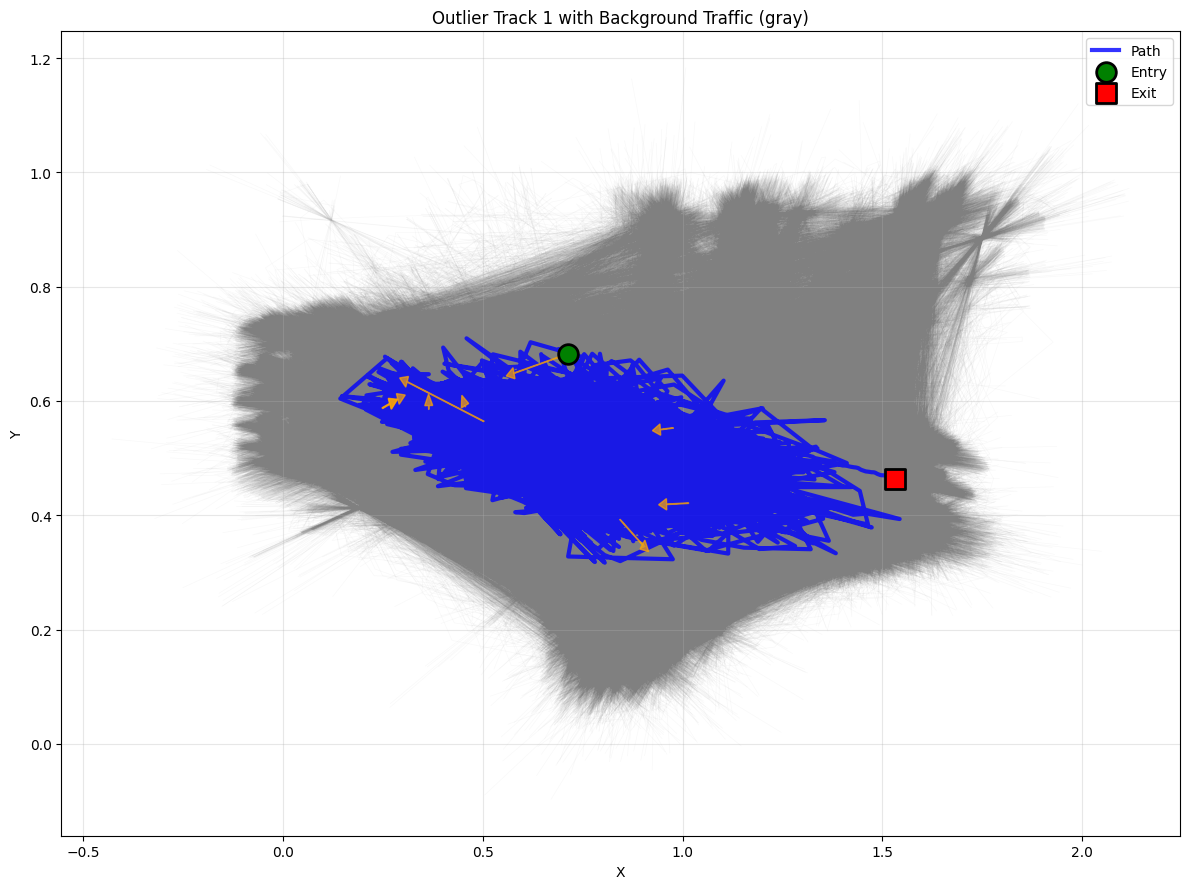

In [76]:
# Show outlier with background context (WARNING: may be slow with many trajectories)
fig, ax = plt.subplots(figsize=(12, 9))
plot_trajectory(most_anomalous_id, ax=ax, show_background=True, background_alpha=0.05)
ax.set_title(f'Outlier Track {int(most_anomalous_id)} with Background Traffic (gray)')
plt.tight_layout()
plt.show()

## Analyze Reachability Threshold

Find percentile thresholds to identify extreme outliers.

Reachability percentiles:
  50th percentile: 0.070 (9306 tracks above)
  75th percentile: 0.101 (4653 tracks above)
  90th percentile: 0.142 (1863 tracks above)
  95th percentile: 0.175 (931 tracks above)
  99th percentile: 0.399 (427 tracks above)


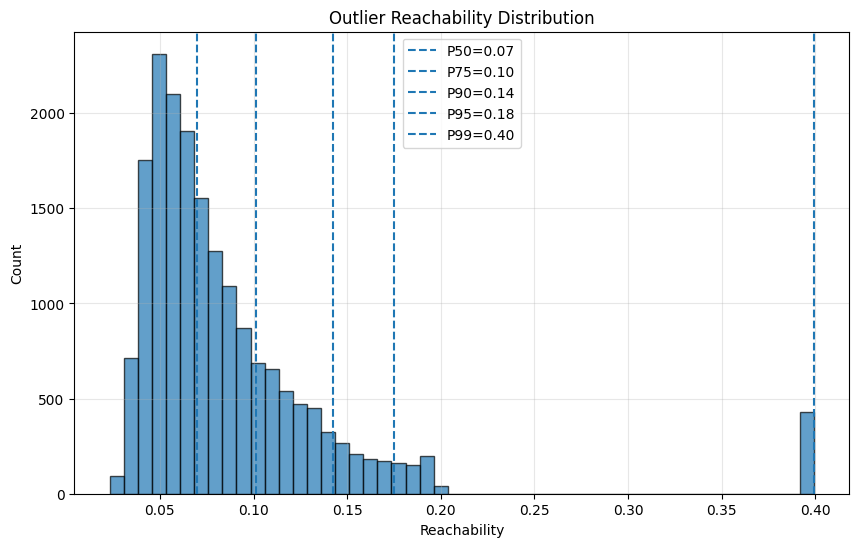

In [77]:
# Find a good threshold to separate "extreme" outliers
percentiles = [50, 75, 90, 95, 99]
thresholds = [outliers['reachability'].quantile(p/100) for p in percentiles]

print("Reachability percentiles:")
for p, t in zip(percentiles, thresholds):
    n_above = (outliers['reachability'] >= t).sum()
    print(f"  {p}th percentile: {t:.3f} ({n_above} tracks above)")

# Visualize
plt.figure(figsize=(10, 6))
plt.hist(outliers['reachability'], bins=50, alpha=0.7, edgecolor='black')
for p, t in zip(percentiles, thresholds):
    plt.axvline(t, linestyle='--', label=f'P{p}={t:.2f}')
plt.xlabel('Reachability')
plt.ylabel('Count')
plt.title('Outlier Reachability Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Export Extreme Outliers

Save the most extreme outliers to CSV for manual review.

In [78]:
# Define threshold (e.g., top 5%)
threshold_percentile = 95
threshold = outliers['reachability'].quantile(threshold_percentile / 100)

extreme_outliers = outliers[outliers['reachability'] >= threshold]
print(f"\nExtreme outliers (>= P{threshold_percentile}): {len(extreme_outliers)}")

# Save to CSV for manual review
extreme_outliers.to_csv(processed_dir / "extreme_outliers.csv", index=False)
print(f"Saved to {processed_dir / 'extreme_outliers.csv'}")

# Display
extreme_outliers[['track_id', 'reachability', 'x_entry', 'y_entry', 'x_exit', 'y_exit']]


Extreme outliers (>= P95): 931
Saved to ../data/processed/bellevue_116th_ne12th/extreme_outliers.csv


,track_id,reachability,x_entry,y_entry,x_exit,y_exit
0,1,0.399410,0.711995,0.682180,1.531162,0.462875
1,11828,0.399410,1.859045,0.992652,0.375000,0.783333
2,2851,0.399410,1.458569,0.788502,1.917572,1.044916
3,18884,0.399410,1.047222,0.780556,1.063194,0.817361
4,11869,0.399410,1.873708,0.298165,0.985800,0.912652
...,...,...,...,...,...,...
926,2293,0.175435,1.654327,0.941982,1.322416,0.658249
927,17127,0.175325,1.305556,0.700694,1.291667,0.681944
928,1071,0.175323,1.313582,0.319840,0.994015,0.560088
929,12523,0.175323,1.255438,0.316604,0.956625,0.548649
